# Statistical Methods Project

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy.stats.mstats import winsorize
import statsmodels.formula.api as smf
import statsmodels.api as sm

# EDA (data description, data preprocessing)

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/ov3ipo/SM_Project/main/life_expectancy.csv")
# remove trailing space in columns name and format display function
pd.options.display.float_format = '{:.4f}'.format
df = df.rename(columns=lambda x: x.strip())

# overview on data statistic
display(df.head(10))
display(df.info())

# get quantitative and qualitative data
numeric_cols = df.drop(columns=["Status", "Country"], axis=1).columns

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0000,263.0000,62,0.0100,71.2796,65.0000,1154,...,6.0000,8.1600,65.0000,0.1000,584.2592,33736494.0000,17.2000,17.3000,0.4790,10.1000
1,Afghanistan,2014,Developing,59.9000,271.0000,64,0.0100,73.5236,62.0000,492,...,58.0000,8.1800,62.0000,0.1000,612.6965,327582.0000,17.5000,17.5000,0.4760,10.0000
2,Afghanistan,2013,Developing,59.9000,268.0000,66,0.0100,73.2192,64.0000,430,...,62.0000,8.1300,64.0000,0.1000,631.7450,31731688.0000,17.7000,17.7000,0.4700,9.9000
3,Afghanistan,2012,Developing,59.5000,272.0000,69,0.0100,78.1842,67.0000,2787,...,67.0000,8.5200,67.0000,0.1000,669.9590,3696958.0000,17.9000,18.0000,0.4630,9.8000
4,Afghanistan,2011,Developing,59.2000,275.0000,71,0.0100,7.0971,68.0000,3013,...,68.0000,7.8700,68.0000,0.1000,63.5372,2978599.0000,18.2000,18.2000,0.4540,9.5000
5,Afghanistan,2010,Developing,58.8000,279.0000,74,0.0100,79.6794,66.0000,1989,...,66.0000,9.2000,66.0000,0.1000,553.3289,2883167.0000,18.4000,18.4000,0.4480,9.2000
6,Afghanistan,2009,Developing,58.6000,281.0000,77,0.0100,56.7622,63.0000,2861,...,63.0000,9.4200,63.0000,0.1000,445.8933,284331.0000,18.6000,18.7000,0.4340,8.9000
7,Afghanistan,2008,Developing,58.1000,287.0000,80,0.0300,25.8739,64.0000,1599,...,64.0000,8.3300,64.0000,0.1000,373.3611,2729431.0000,18.8000,18.9000,0.4330,8.7000
8,Afghanistan,2007,Developing,57.5000,295.0000,82,0.0200,10.9102,63.0000,1141,...,63.0000,6.7300,63.0000,0.1000,369.8358,26616792.0000,19.0000,19.1000,0.4150,8.4000
9,Afghanistan,2006,Developing,57.3000,295.0000,84,0.0300,17.1715,64.0000,1990,...,58.0000,7.4300,58.0000,0.1000,272.5638,2589345.0000,19.2000,19.3000,0.4050,8.1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

None

## Data description

### Univariate

#### Qualitative

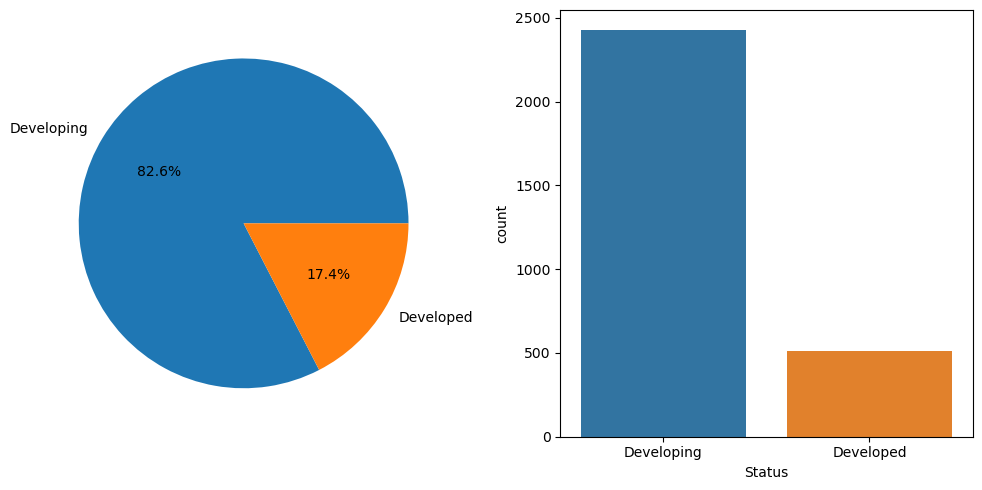

In [6]:
plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1)
x = df['Status'].value_counts().reset_index()
plt.pie(x=x['count'], labels=x['Status'], autopct="%0.1f%%")
plt.subplot(1, 2, 2)
sns.countplot(df, x="Status")
plt.tight_layout()
plt.show()

``` {markdown}
Remark:
- Why didn't we consider the Country col in this case?
- State what you see in the chart
```

#### Quantitative

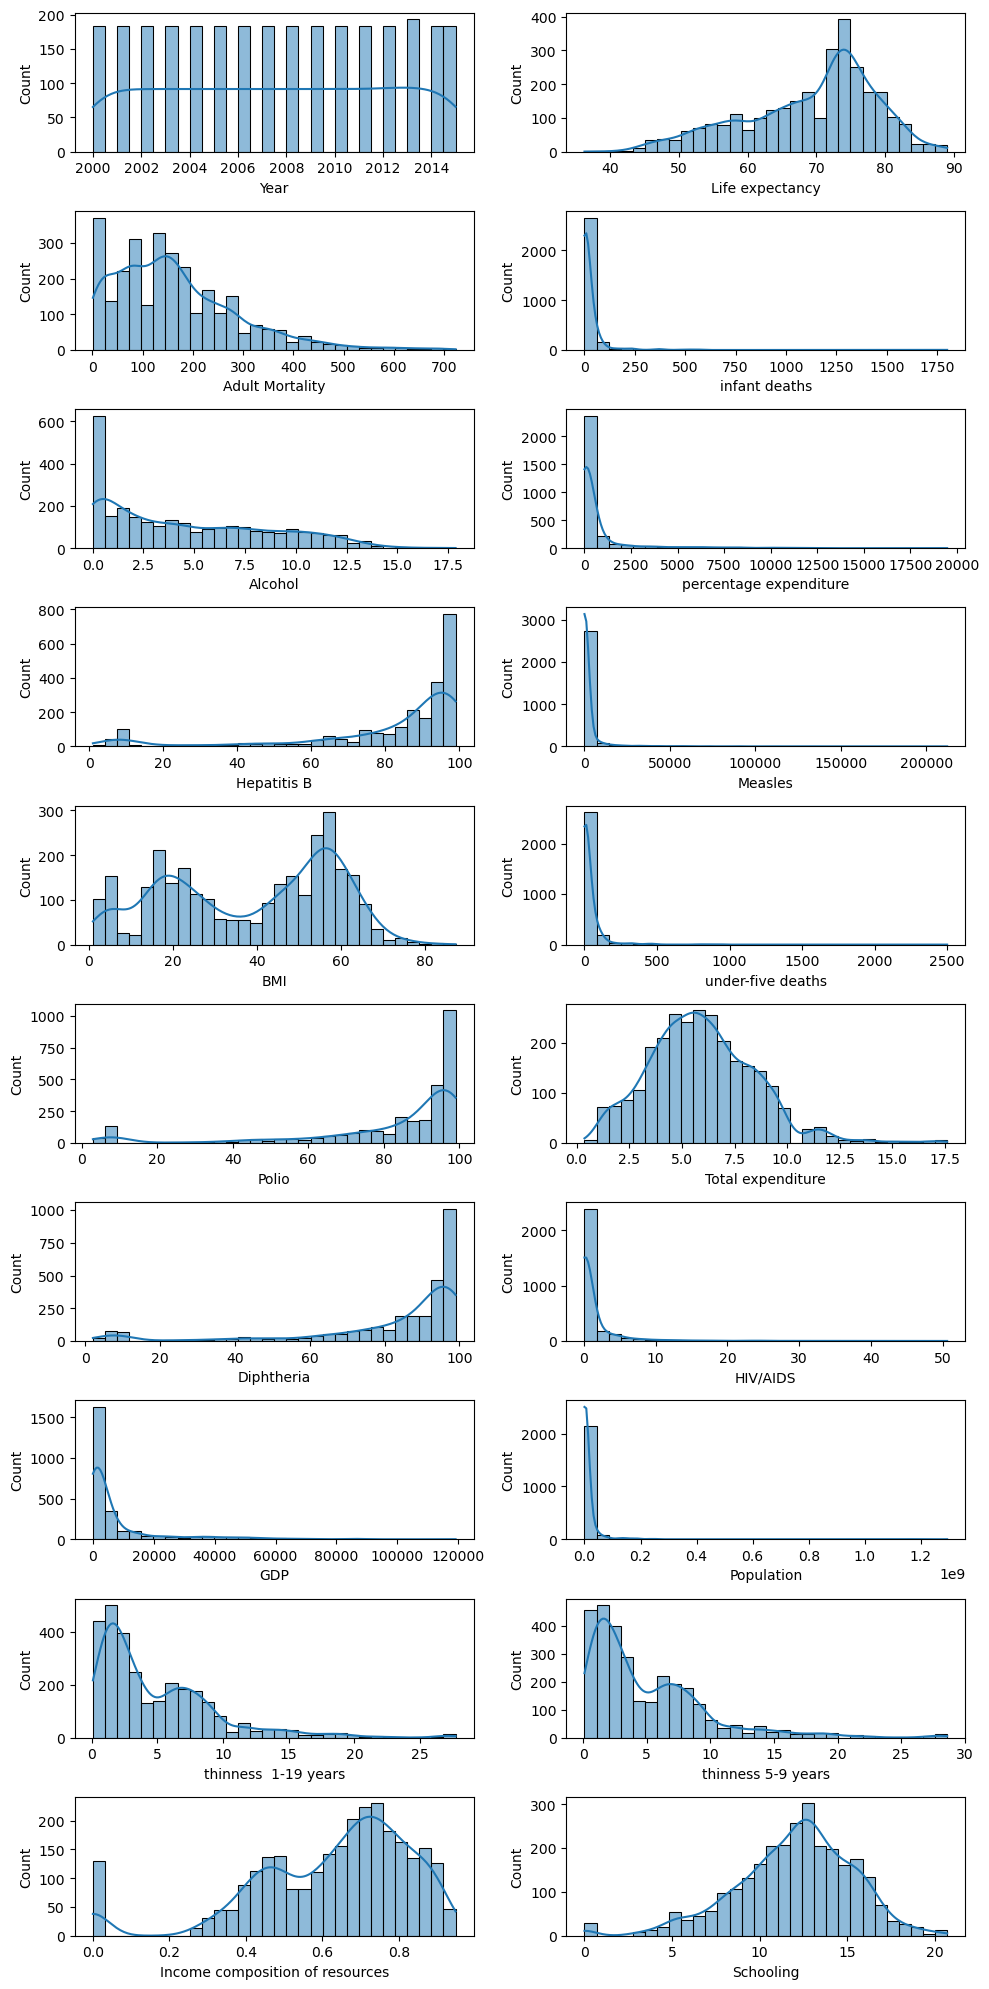

In [7]:
plt.figure(figsize=(10, 20))
for i, col in enumerate(numeric_cols):
    plt.subplot(10, 2, i + 1)
    sns.histplot(df, x=col, bins=30, kde=True)
plt.tight_layout()
plt.show()

``` {markdown}
Remark:
- State what you see in the chart
```

### Bivariate

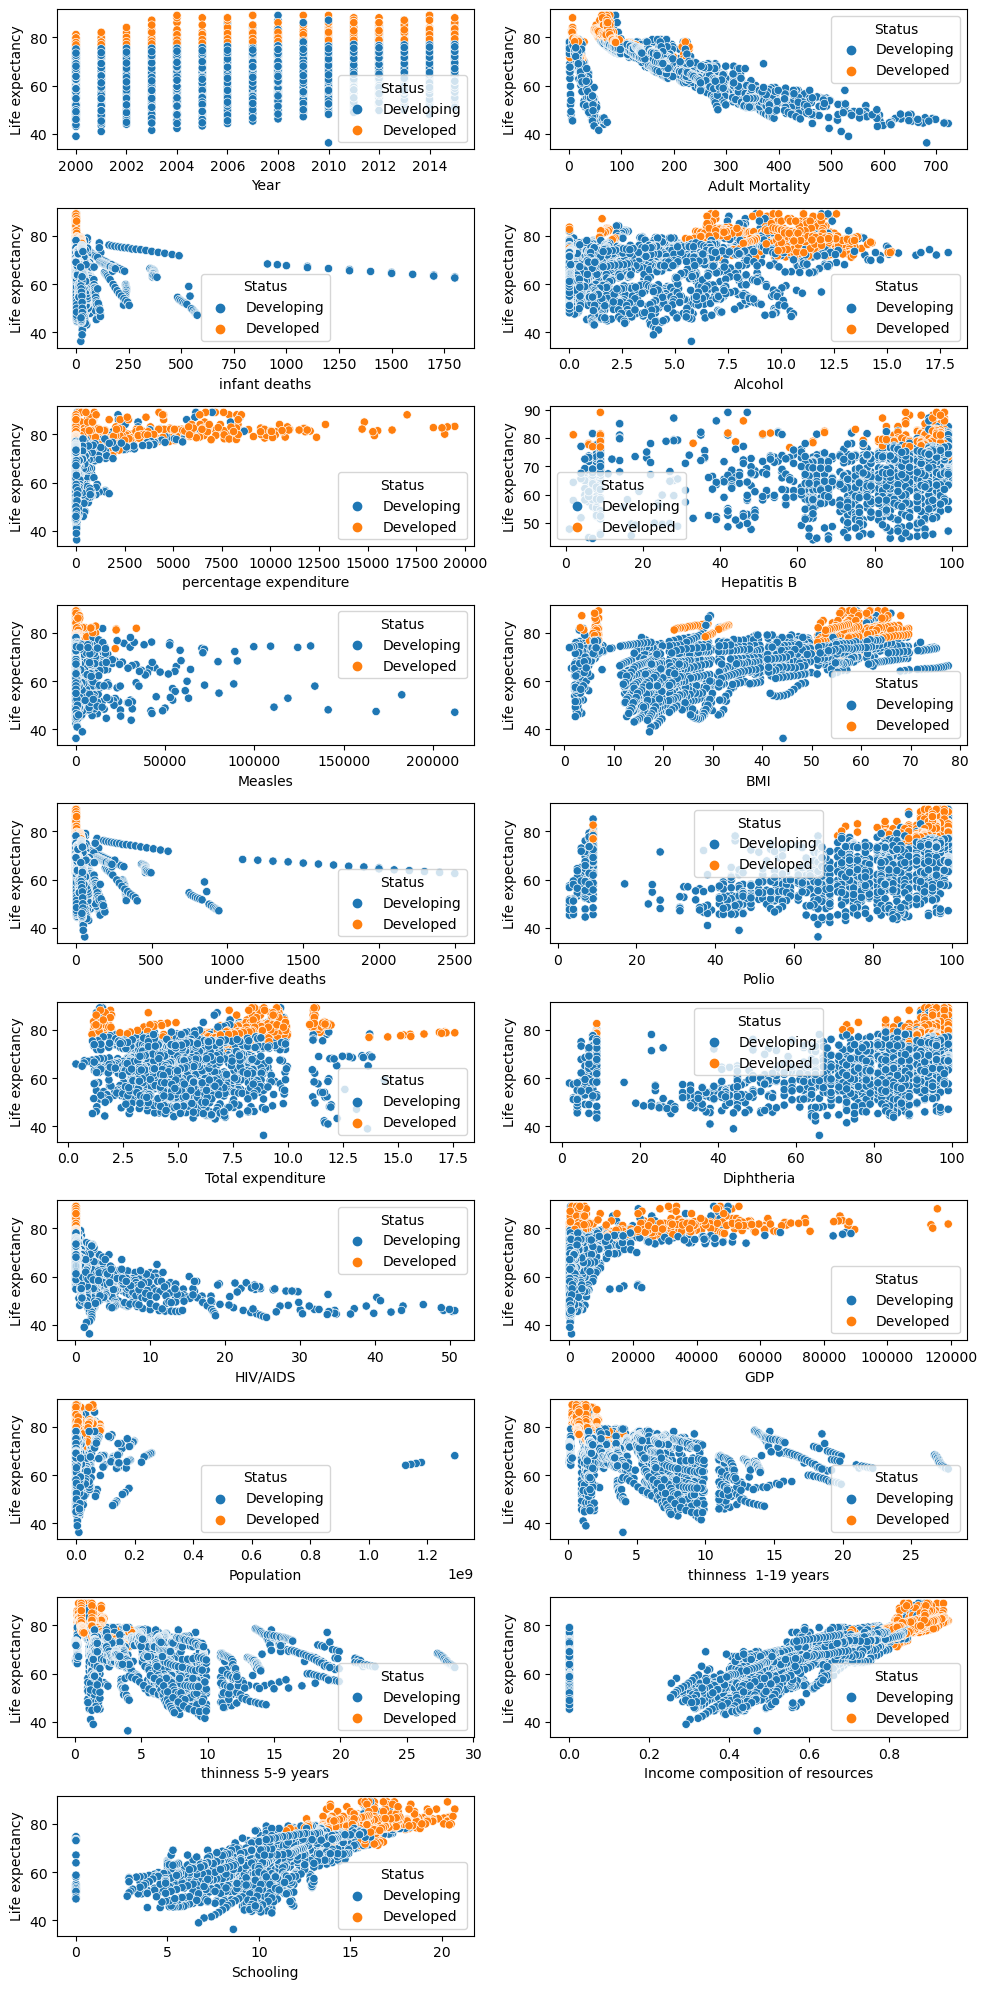

In [8]:
plt.figure(figsize=(10, 20))
index = np.argwhere(numeric_cols=="Life expectancy")
for i, col in enumerate(np.delete(numeric_cols, index)):
    plt.subplot(10, 2, i + 1)
    sns.scatterplot(df, x=col, y="Life expectancy", hue="Status", legend="auto")
plt.tight_layout()
plt.show()

``` {markdown}
Remark:
- State what you see in the chart
- Base on the scatter plot can you spot any variables that seem to have a linear relationship with the target variabel?
```

### Overall statistic

In [9]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Year,2938.0000,2007.5187,4.6138,2000.0000,2004.0000,2008.0000,2012.0000,2015.0000
Life expectancy,2928.0000,69.2249,9.5239,36.3000,63.1000,72.1000,75.7000,89.0000
Adult Mortality,2928.0000,164.7964,124.2921,1.0000,74.0000,144.0000,228.0000,723.0000
infant deaths,2938.0000,30.3039,117.9265,0.0000,0.0000,3.0000,22.0000,1800.0000
Alcohol,2744.0000,4.6029,4.0524,0.0100,0.8775,3.7550,7.7025,17.8700
percentage expenditure,2938.0000,738.2513,1987.9149,0.0000,4.6853,64.9129,441.5341,19479.9116
Hepatitis B,2385.0000,80.9405,25.0700,1.0000,77.0000,92.0000,97.0000,99.0000
Measles,2938.0000,2419.5922,11467.2725,0.0000,0.0000,17.0000,360.2500,212183.0000
BMI,2904.0000,38.3212,20.0440,1.0000,19.3000,43.5000,56.2000,87.3000
under-five deaths,2938.0000,42.0357,160.4455,0.0000,0.0000,4.0000,28.0000,2500.0000


## Data preprocessing (NAs, outliers, duplicateds, label encoding)

### Missing

In [10]:
print("\nPreprocessing\n")
print(df.isna().sum())
df = df.interpolate(method='linear', limit_direction='forward')
print("\nPostprocessing\n")
print(df.isna().sum())


Preprocessing

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

Postprocessing

Country                            0
Year                               0
Status                

### Duplicated

In [11]:
print(f"Total duplicated values: {df.duplicated().sum()}")

Total duplicated values: 0


### Outliers

#### Detect outliers

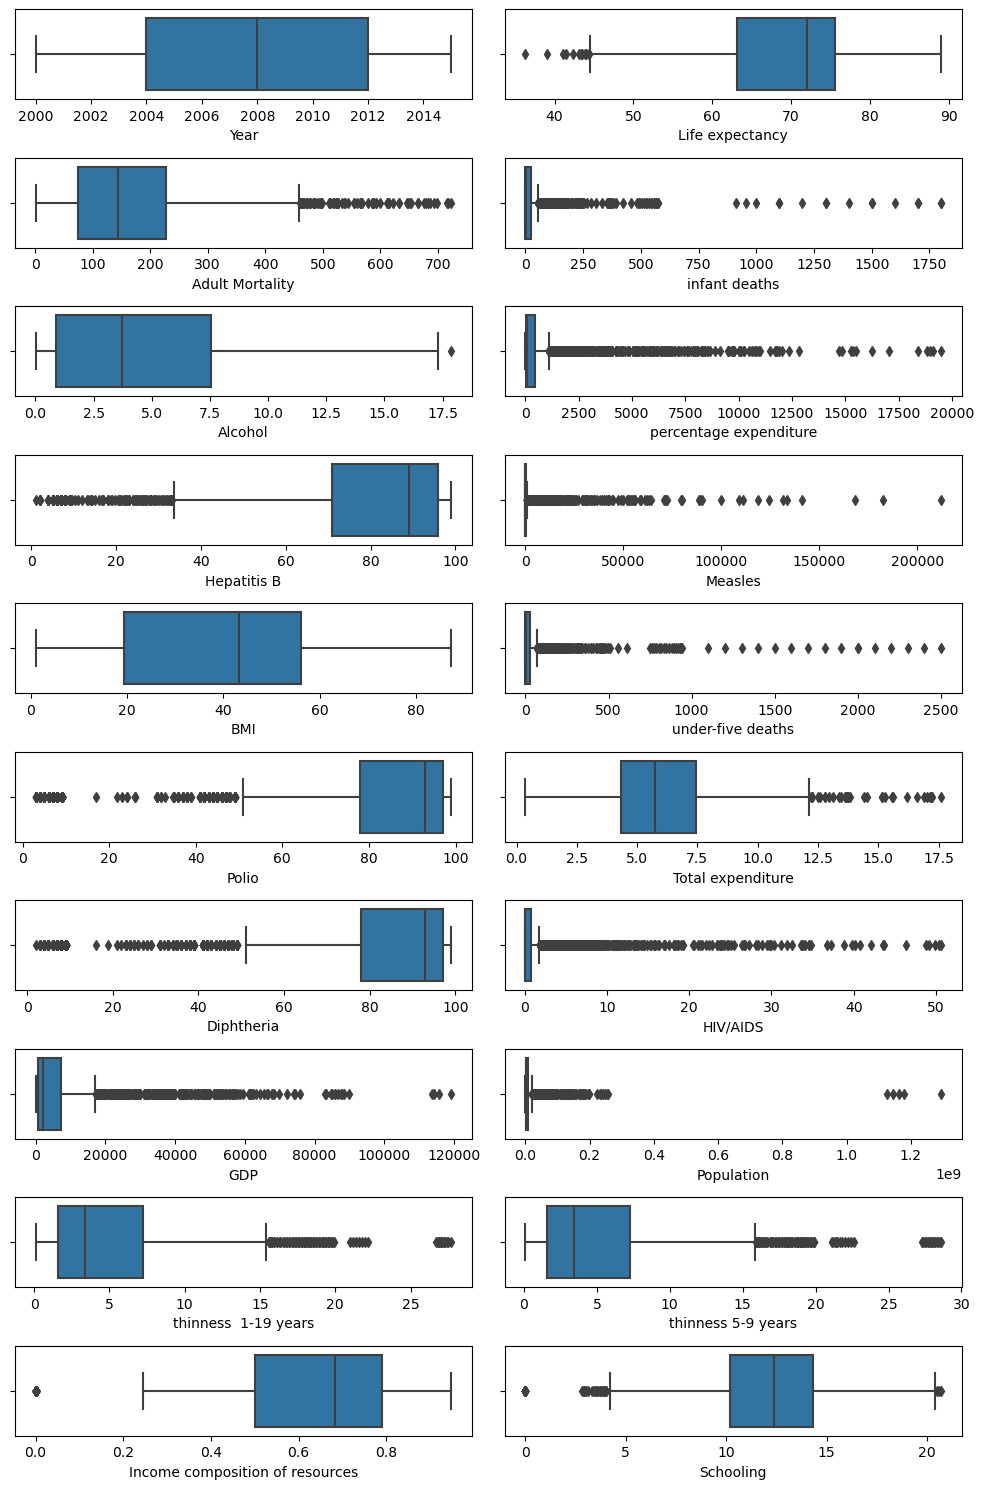

,Total outliers
Year,0
Life expectancy,12
Adult Mortality,82
infant deaths,315
Alcohol,1
percentage expenditure,389
Hepatitis B,248
Measles,542
BMI,0
under-five deaths,394


In [12]:
plt.figure(figsize=(10, 15))
for i, col in enumerate(numeric_cols):
    plt.subplot(10, 2, i + 1)
    sns.boxplot(df, x=col)
plt.tight_layout()
plt.show()

# detect outliers
def detectOutliers(data):
    outliers_arr = []
    for col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col].count()
        outliers_arr.append(outliers)
    return pd.DataFrame(outliers_arr, index=data.columns, columns=["Total outliers"])

numeric_data = df.drop(columns=["Status", "Country"], axis=1)
outliers = detectOutliers(numeric_data)
outliers

``` {markdonw}
Why we should not use variable with high outliers -> because regression can heavily be affected by these outliers, hence we should only choose those with low outliers
Potential variable for regression of target
- Year
- Adult Mortality
- Alcohol
- BMI
- Total expenditure
- thinness 1-19 years
- thinness 5-9 years
- Income composition of resources
- Schooling
```

#### Dealing with outliers

In [13]:
# get potentital variables and variables that have outliers
potential_var = outliers[(outliers["Total outliers"] < 150)].index
outliers_var = outliers[(outliers["Total outliers"] > 0) & (outliers["Total outliers"] < 150)].index

# using transformation to deal with outliers
df_outliers = df.copy()
for col in outliers_var:
    if col != "Life expectancy":
        df_outliers[col] = np.sqrt(df_outliers[col])

# detect outliers again
display(detectOutliers(df_outliers[potential_var]))

# notice that outliers of Total expenditure, Income composition of resources and schooling does not change and or increase
for col in ["Total expenditure", "Income composition of resources", "Schooling"]:
    df_outliers[col] = df[col]
    df_outliers[col] = winsorize(df_outliers[col], limits=[0.05, 0.05])

# detect outliers again
display(detectOutliers(df_outliers[potential_var]))

,Total outliers
Year,0
Life expectancy,12
Adult Mortality,18
Alcohol,0
BMI,0
Total expenditure,46
thinness 1-19 years,16
thinness 5-9 years,16
Income composition of resources,130
Schooling,107


,Total outliers
Year,0
Life expectancy,12
Adult Mortality,18
Alcohol,0
BMI,0
Total expenditure,0
thinness 1-19 years,16
thinness 5-9 years,16
Income composition of resources,0
Schooling,0


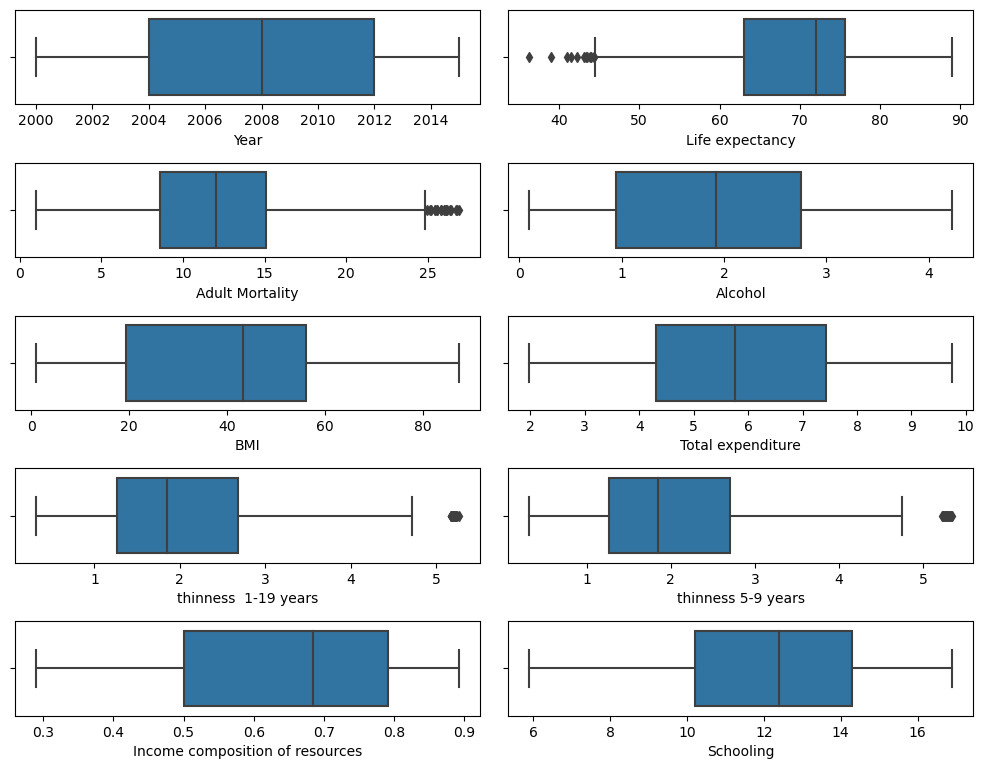

In [14]:
# plot outliers
plt.figure(figsize=(10, 15))
for i, col in enumerate(potential_var):
    plt.subplot(10, 2, i + 1)
    sns.boxplot(df_outliers, x=col)
plt.tight_layout()
plt.show()

# assign new dataframe to use for regression
df_regress = df_outliers[potential_var]

``` {markdown}
Remark
- Explain reason why we should not use variables that have many outliers
- Explain reason why we choose to use transformation and why is log (or anything else)
```

### Comprare preprocess and postprocess

In [15]:
# compare statistic
display(df[potential_var].describe().T)
display(df_regress.describe().T)

,count,mean,std,min,25%,50%,75%,max
Year,2938.0000,2007.5187,4.6138,2000.0000,2004.0000,2008.0000,2012.0000,2015.0000
Life expectancy,2938.0000,69.2149,9.5108,36.3000,63.1000,72.0000,75.6000,89.0000
Adult Mortality,2938.0000,164.7446,124.2266,1.0000,74.0000,144.0000,228.0000,723.0000
Alcohol,2938.0000,4.5502,3.9948,0.0100,0.9025,3.7025,7.5500,17.8700
BMI,2938.0000,38.2987,19.9914,1.0000,19.3250,43.2500,56.1000,87.3000
Total expenditure,2938.0000,5.9406,2.4457,0.3700,4.3125,5.7550,7.4400,17.6000
thinness 1-19 years,2938.0000,4.8823,4.4334,0.1000,1.6000,3.4000,7.2000,27.7000
thinness 5-9 years,2938.0000,4.9204,4.5325,0.1000,1.6000,3.4000,7.3000,28.6000
Income composition of resources,2938.0000,0.6344,0.2096,0.0000,0.5000,0.6840,0.7911,0.9480
Schooling,2938.0000,12.0752,3.3430,0.0000,10.2000,12.4000,14.3000,20.7000


,count,mean,std,min,25%,50%,75%,max
Year,2938.0000,2007.5187,4.6138,2000.0000,2004.0000,2008.0000,2012.0000,2015.0000
Life expectancy,2938.0000,69.2149,9.5108,36.3000,63.1000,72.0000,75.6000,89.0000
Adult Mortality,2938.0000,11.8344,4.9700,1.0000,8.6023,12.0000,15.0997,26.8887
Alcohol,2938.0000,1.8375,1.0836,0.1000,0.9500,1.9242,2.7477,4.2273
BMI,2938.0000,38.2987,19.9914,1.0000,19.3250,43.2500,56.1000,87.3000
Total expenditure,2938.0000,5.8642,2.1513,1.9800,4.3125,5.7550,7.4400,9.7500
thinness 1-19 years,2938.0000,1.9989,0.9417,0.3162,1.2649,1.8439,2.6833,5.2631
thinness 5-9 years,2938.0000,2.0007,0.9582,0.3162,1.2649,1.8439,2.7019,5.3479
Income composition of resources,2938.0000,0.6464,0.1750,0.2900,0.5000,0.6840,0.7911,0.8920
Schooling,2938.0000,12.1127,2.9745,5.9000,10.2000,12.4000,14.3000,16.9000


``` {markdown}
Remark:
- State what you observe when compare the two tables
```

# Linear Regression Analysis

## Correlation Matrix

### Before dealing with outliers

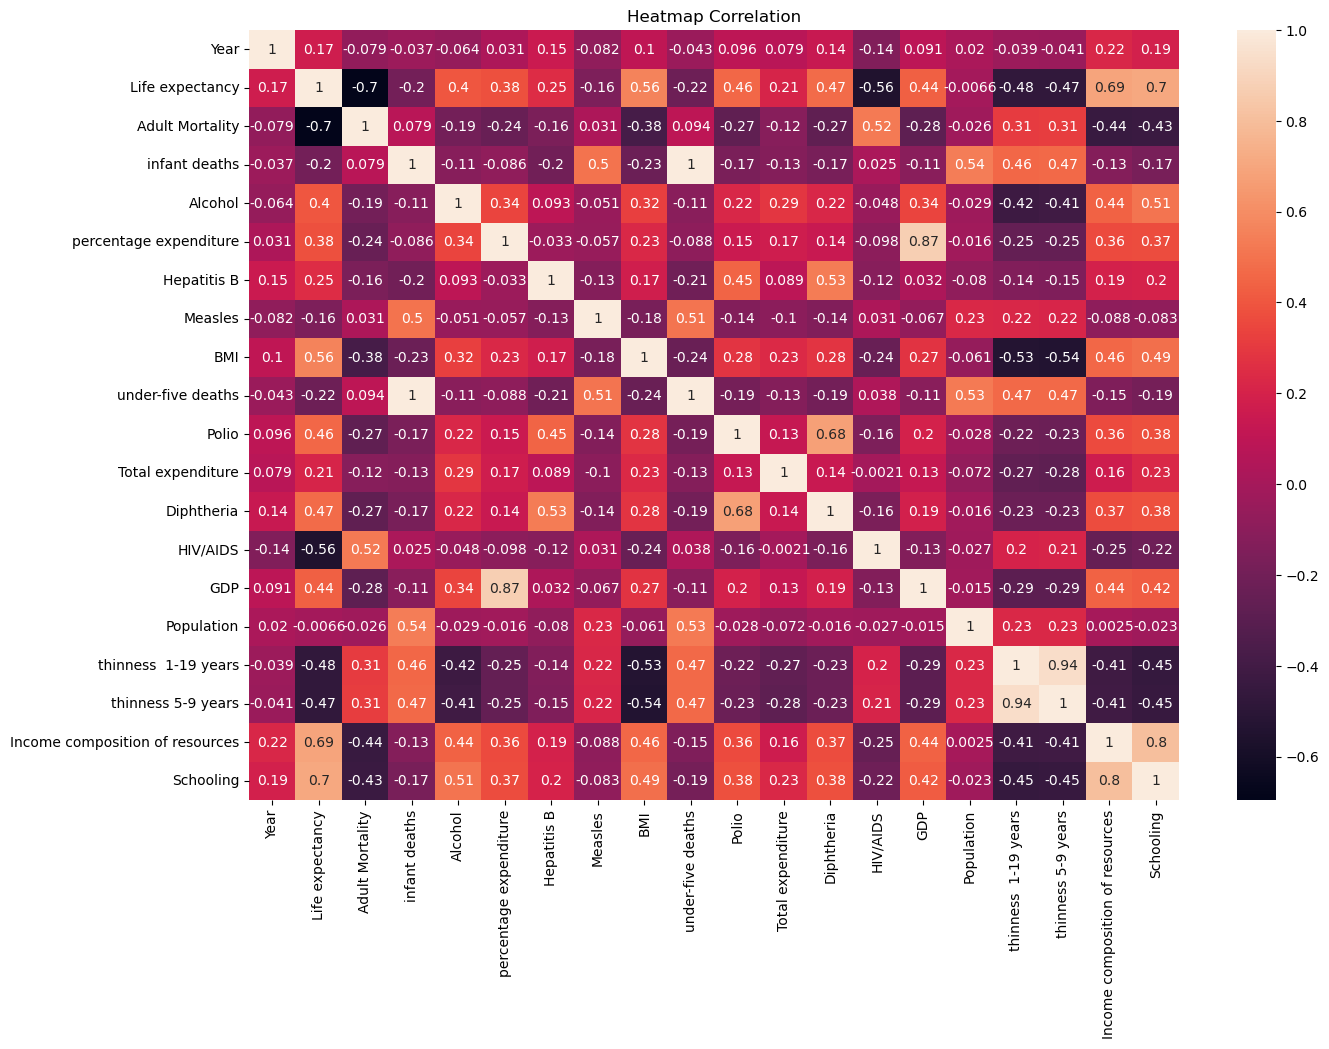

Variables have correlation larger than 0.5: 


Adult Mortality                   -0.6957
BMI                                0.5564
HIV/AIDS                          -0.5559
Income composition of resources    0.6909
Schooling                          0.7043
Name: Life expectancy, dtype: float64

In [16]:
numeric_df = df.drop(columns=["Country", "Status"])
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df.corr(), annot=True)
plt.title('Heatmap Correlation')
plt.show()

# get variables that has high correlation with Life expectancy
corrs = numeric_df.corr()['Life expectancy'].drop('Life expectancy')
high_corr = corrs[corrs.abs() > 0.5]
print("Variables have correlation larger than 0.5: ")
high_corr

### After dealing with outliers

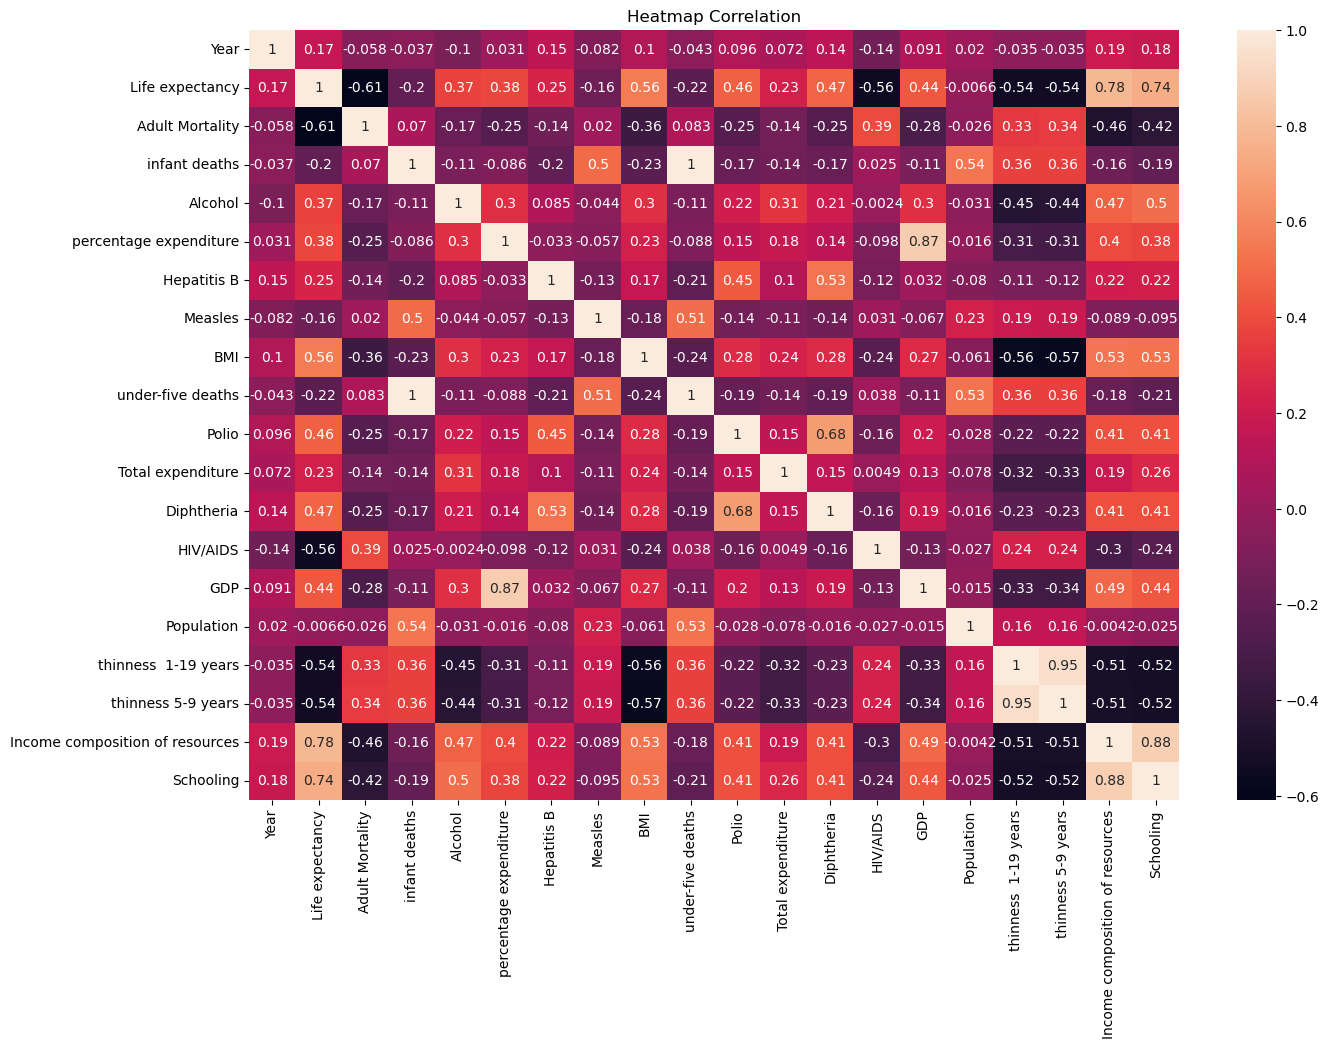

Variables have correlation larger than 0.5: 


Adult Mortality                   -0.6085
BMI                                0.5564
HIV/AIDS                          -0.5559
thinness  1-19 years              -0.5355
thinness 5-9 years                -0.5379
Income composition of resources    0.7837
Schooling                          0.7375
Name: Life expectancy, dtype: float64

In [17]:
numeric_df_outliers = df_outliers.drop(columns=["Country", "Status"])
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_df_outliers.corr(), annot=True)
plt.title('Heatmap Correlation')
plt.show()

# get variables that has high correlation with Life expectancy
corrs = numeric_df_outliers.corr()['Life expectancy'].drop('Life expectancy')
high_corr = corrs[corrs.abs() > 0.5]
print("Variables have correlation larger than 0.5: ")
high_corr

Remark
- We have 8 variables having correlation larger than 0.5.
- Base on the heatmap above, we have two couples "Schooling"-"Income composition of resources",and "thinness  1-19 years"-"thinness 5-9 years " have high correlation with each other, so they are multicollinearity and do not satisfy the condition of linear regression.
- According to the outliers detection in the previous step, we can see that "HIV/AIDS" have more outliers than the others.
- Therefore, This leaves us with the last 2 variables that is BMI and Adult Mortality, hence we will use them for linear regression. 

In [18]:
# update data use for regress
df_regress = df_regress[["Life expectancy", "BMI", "Adult Mortality"]]

``` {markdown}
Remark
- Base on qualitative analysis remark, outliers detection remark, and this correlation matix make the final conclusion on which variable we should use for linear regression of target
- thiness 1-19 and 5-9 have high correlation with each other, also for income composition of resources make them not satisfy the condition of linear regression that is each variables should be independent
- HIV/AIDS is introduced in here but it has too much outliers hence we will skip it
- This leaves us with the last 2 variables that is BMI and Adult Mortality, hence we will use them for linear regression
```

## Least square regression

### $ \hat{Y} = Intercept + Slope*X $
$Slope = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{n}(x_i - \bar{x})^2}                   $ <br>
$Intercept = \bar{y} - Slope*\bar{x}$               <br>
<br>
$R^2 = \frac{\sum_{i=1}^n (\hat{y}i - \bar{y})^2}{\sum{i=1}^n (y_i - \bar{y})^2}$ <br>
<br>
The coefficient of determination, $R^2$, measures the proportion of the variance in the dependent variable that is predictable from the independent variable(s). It ranges from 0 to 1, with a higher value indicating a better fit of the model to the data.

In [34]:
X1 = df_regress['Adult Mortality']
X2 = df_regress['BMI']
y = df_regress['Life expectancy']

model1 = smf.ols(formula='y ~ X1', data=df_regress).fit()
residual1 = model1.resid
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     1726.
Date:                Mon, 03 Jun 2024   Prob (F-statistic):          3.98e-297
Time:                        13:57:46   Log-Likelihood:                -10107.
No. Observations:                2938   AIC:                         2.022e+04
Df Residuals:                    2936   BIC:                         2.023e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     82.9944      0.360    230.707      0.0

Remark
- The R-squared value is 0.370. This indicates that the independent variable(s), "Adult Mortality", in the model explain 37.0% of the variation in the dependent variable. 
- The Adjusted R-squared value is also 0.370, which suggests that the inclusion of additional predictor variables would not significantly improve the model's explanatory power.

In [35]:
model2 = smf.ols(formula='y ~ X2', data=df_regress).fit()
residual2 = model2.resid
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     1317.
Date:                Mon, 03 Jun 2024   Prob (F-statistic):          1.61e-238
Time:                        13:57:47   Log-Likelihood:                -10242.
No. Observations:                2938   AIC:                         2.049e+04
Df Residuals:                    2936   BIC:                         2.050e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.0764      0.315    187.448      0.0

Remark
- The Adjusted R-squared value is 0.309, which indicates that the independent variables in the model explain approximately 30.9% of the variation in the dependent variable.

- The R-squared value is 0.310, which is slightly higher than the Adjusted R-squared. This suggests that the inclusion of additional predictor variables may not significantly improve the model's explanatory power.

In [36]:
model3 = smf.ols(formula='y ~ X1 + X2', data=df_regress).fit()
residual3 = model3.resid
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     1481.
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:57:47   Log-Likelihood:                -9760.8
No. Observations:                2938   AIC:                         1.953e+04
Df Residuals:                    2935   BIC:                         1.955e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.7670      0.486    149.622      0.0

Remark

- The R-squared value is 0.502, indicating that the model explains 50.2% of the variation in the dependent variable.
- The Adjusted R-squared value is 0.502, which is the same as the R-squared value. This suggests that the inclusion of the independent variables in the model does not significantly improve the model's explanatory power beyond what the R-squared value already captures.


## Check residuals for 4 assumptions

### Assumption 1: Linearity

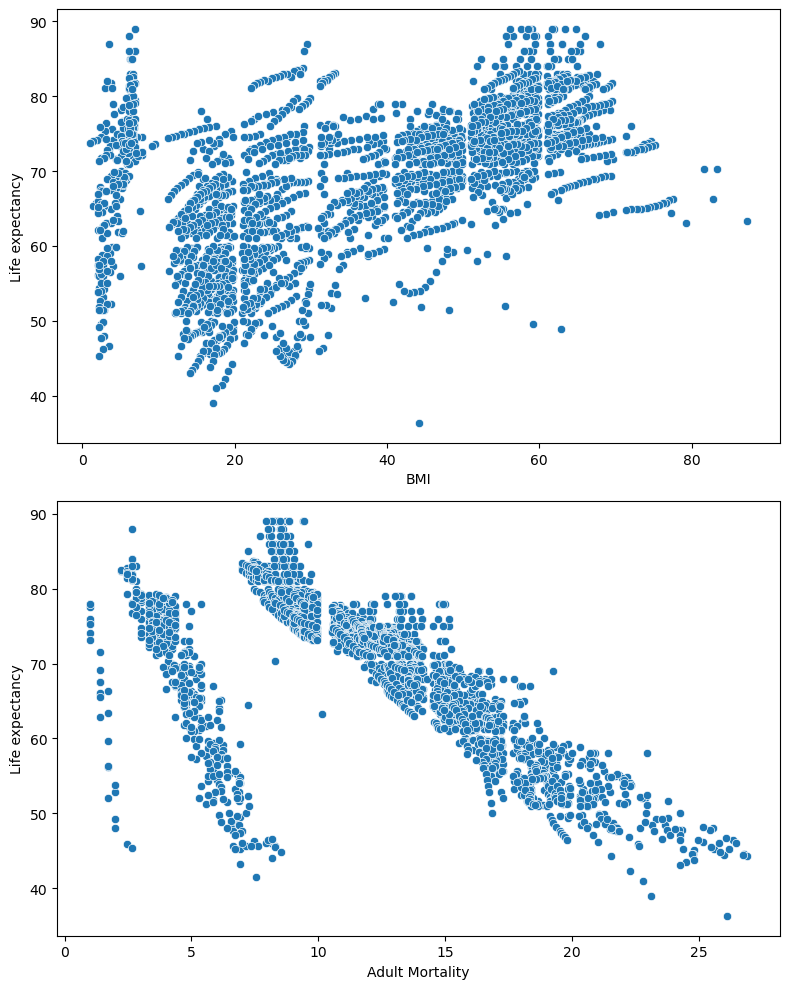

In [37]:
plt.figure(figsize=(8, 10))
for i, col in enumerate(df_regress.drop(['Life expectancy'], axis=1).columns):
    plt.subplot(2, 1, i + 1)
    sns.scatterplot(df_regress, x=col, y="Life expectancy")
plt.tight_layout()
plt.show()

``` {markdonw}
Remark
- What does the chart conclude about the liearity?
- What to do if this assumption is violated?
```

### Assumption 2: Independent

``` {markdonw}
Remark
- What does the chart conclude about the linearity?
- What to do if this assumption is violated?
```

### Assumption 3: Homoscedasticity

``` {markdonw}
Remark
- What does the chart conclude about the linearity?
- What to do if this assumption is violated?
```

### Assumption 4: Normality of Residuals

# ----------------------- raw

### Assumption 2: Homoscedasticity

In [56]:
def Check_Homo(residual,model_input):
    # Homoscedasticity (White test)
    white_test = het_white(residual, model_input.model.exog)
    print(f'White test: Test statistic = {white_test[0]}, p-value = {white_test[1]}')

    if white_test[1] <= 0.05:
        print("There is significant evidence of heteroscedasticity.\n => This implies that the assumption of homoscedasticity is violated.")
    else :
        print("There is no significant evidence to suggest heteroscedasticity.\n => This implies that the assumption of homoscedasticity is likely satisfied.")
    

Test for "Adult Mortality"

In [57]:
Check_Homo(residual1,model1)

White test: Test statistic = 267.92833001007443, p-value = 6.6084919534672355e-59
There is significant evidence of heteroscedasticity.
 => This implies that the assumption of homoscedasticity is violated.


Test for "BMI"

In [58]:
Check_Homo(residual2,model2)

White test: Test statistic = 497.8175883753264, p-value = 7.948481854143584e-109
There is significant evidence of heteroscedasticity.
 => This implies that the assumption of homoscedasticity is violated.


Test for "Adult Mortality" and "BMI"

In [59]:
Check_Homo(residual3,model3)

White test: Test statistic = 759.3306959238912, p-value = 7.254614682089603e-162
There is significant evidence of heteroscedasticity.
 => This implies that the assumption of homoscedasticity is violated.


### Assumption 2: Independent


The Durbin-Watson test is used to detect the presence of autocorrelation in the residuals of a regression model. Autocorrelation refers to the correlation between the residuals of the model, which violates the assumption of independent errors.

The Durbin-Watson test statistic, denoted as "d", can range from 0 to 4. The interpretation of the Durbin-Watson statistic is as follows:

    If d = 2, it indicates no autocorrelation.
    If d < 1.5, it suggests positive autocorrelation.
    If d > 2.5, it suggests negative autocorrelation.
    If d is between 1.5 and 2.5, it generally indicates no autocorrelation.


In [55]:
def Check_independent(residual):
    dw_statistic = durbin_watson(residual)
    print(f'Durbin-Watson statistic: {dw_statistic}')
    if 1.5<dw_statistic<2.5 :
        print("A value indicates no autocorrelation.")
    elif dw_statistic < 1.5:
        print("A value indicates positive autocorrelation")
    else:
        print("A value indicates negative autocorrelation")

Test for "Adult Mortality"

In [52]:
Check_independent(residual1)

Durbin-Watson statistic: 0.6473907770675877
A value indicates positive autocorrelation


Test for "BMI"

In [53]:
Check_independent(residual2)

Durbin-Watson statistic: 0.40526816911712676
A value indicates positive autocorrelation


Test for "Adult Mortality" and "BMI"

In [54]:
Check_independent(residual3)

Durbin-Watson statistic: 0.7163614346493455
A value indicates positive autocorrelation


Assumption 4: Normality of Residuals

In [60]:
def check_Normality(residuals):
    sm.qqplot(residuals, line ='45')
    plt.title('Q-Q plot')
    plt.show()
    # Normality (Shapiro-Wilk test)
    shapiro_test = shapiro(residuals)
    print(f'Shapiro-Wilk test: Test statistic = {shapiro_test[0]}, p-value = {shapiro_test[1]}')
    if shapiro_test[1] > 0.05:
        print("There is no significant evidence to suggest that the residuals are not normally distributed.\n => This implies that the normality assumption is likely satisfied.")
    else :
        print("There is significant evidence that the residuals are not normally distributed.\n => This implies that the normality assumption is violated.")


Test for "BMI"

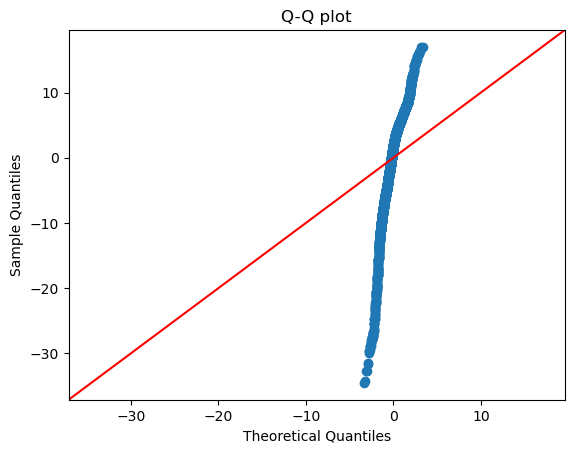

Shapiro-Wilk test: Test statistic = 0.9143821597099304, p-value = 6.82441264384419e-38
There is significant evidence that the residuals are not normally distributed.
 => This implies that the normality assumption is violated.


In [62]:
check_Normality(residual1)

Test for "Adult Mortality"

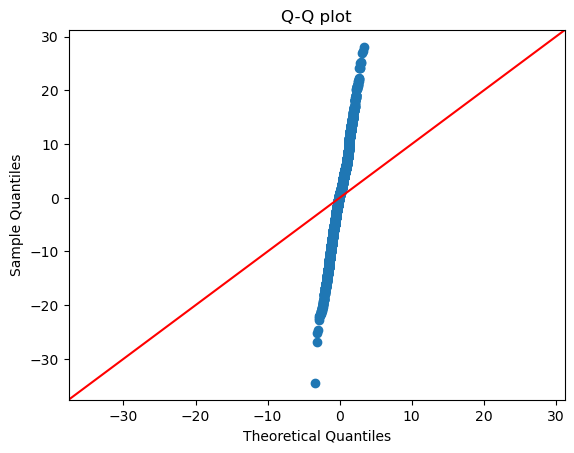

Shapiro-Wilk test: Test statistic = 0.9908168315887451, p-value = 8.490650131760813e-13
There is significant evidence that the residuals are not normally distributed.
 => This implies that the normality assumption is violated.


In [63]:
check_Normality(residual2)

Test for "Adult Mortality" and "BMI"

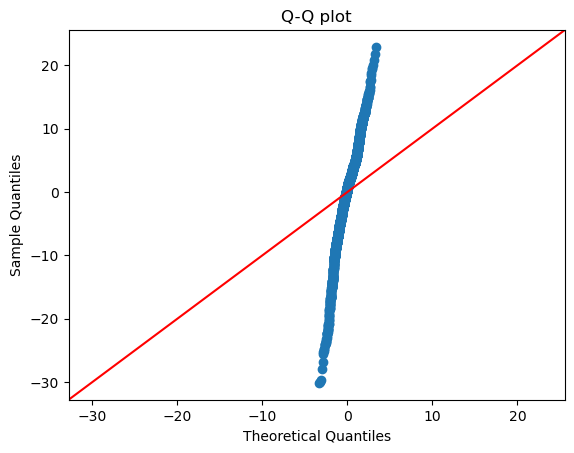

Shapiro-Wilk test: Test statistic = 0.9650994539260864, p-value = 4.3123790126126145e-26
There is significant evidence that the residuals are not normally distributed.
 => This implies that the normality assumption is violated.


In [64]:
check_Normality(residual3)

# ----------------- raw

In [ ]:
# test = shapiro(df_regress[])
# print(f'Test statistic = {test[0]}, p-value = {test[1]}')
# if test[1] > 0.05: print(f'{col} looks normal distributed (fail to reject H0)\n')
# else: print(f'{col} does not normal distributed (reject H0)\n')

``` {markdonw}
Remark
- What does the chart conclude about the linearity?
- What to do if this assumption is violated?
```

## Normality check

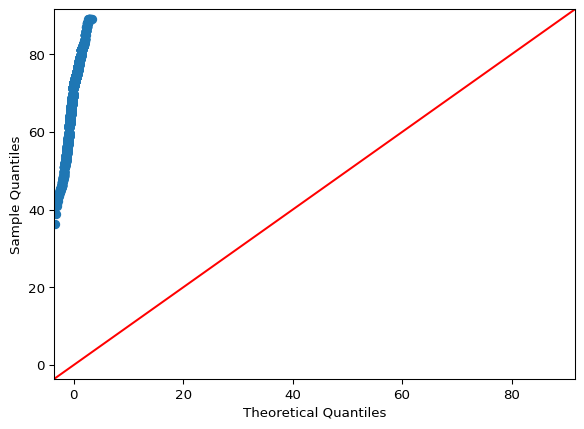

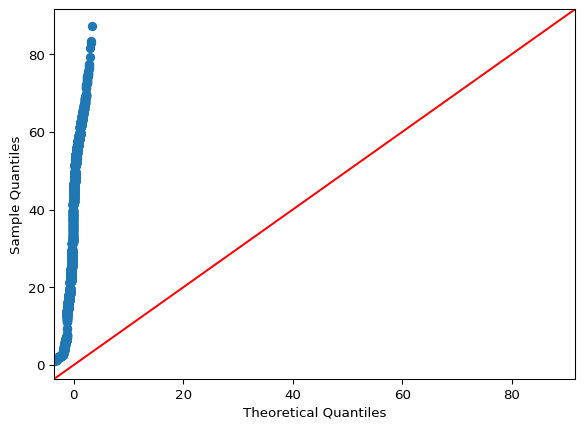

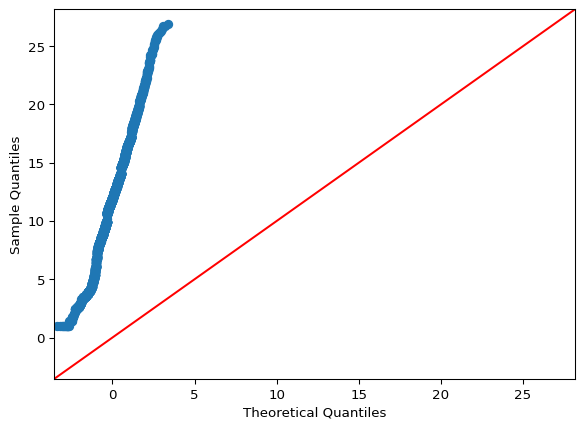

In [ ]:
# add semicolon to prevent duplicated graph issue
sm.qqplot(df_regress["Life expectancy"], line='45');
sm.qqplot(df_regress['BMI'], line='45');
sm.qqplot(df_regress['Adult Mortality'], line='45');

In [ ]:
# use Shapiro-Wilk test to test again
for col in df_regress.columns:
    test = shapiro(df_regress[col])
    print(f'Test statistic = {test[0]}, p-value = {test[1]}')
    if test[1] > 0.05: print(f'{col} looks normal distributed (fail to reject H0)\n')
    else: print(f'{col} does not normal distributed (reject H0)\n')

Test statistic = 0.9566212771358409, p-value = 9.704783341258267e-29
Life expectancy does not normal distributed (reject H0)

Test statistic = 0.9312720150595797, p-value = 8.652378014696785e-35
BMI does not normal distributed (reject H0)

Test statistic = 0.9896294475629359, p-value = 8.478434350053438e-14
Adult Mortality does not normal distributed (reject H0)


``` {markdown}
Remark
- State what you see and what to do next?
```

## Construct confidence interval

## Perform hypothesis testing